In [2]:
suppressPackageStartupMessages(library(Biostrings))
suppressPackageStartupMessages(library(tidyverse))
suppressPackageStartupMessages(library(rasilabRtemplates))
suppressPackageStartupMessages(library(boot))
suppressPackageStartupMessages(library(readxl))
suppressPackageStartupMessages(library(ggrepel))
suppressPackageStartupMessages(library(plotrix))

barcode_reads_cutoff <- 10
n_barcodes_cutoff <- 2

### Global plotting themes

In [3]:
theme <- theme(
        title = element_text(margin = margin(t=0, r=2, b=2, l=2), size=8),
        axis.title.x = element_text(margin = margin(t=2, r=2, b=0, l=2), size=8),
        axis.title.y = element_text(margin = margin(t=2, r=2, b=2, l=0), size=8),
        text = element_text(size = 8),
        legend.text=element_text(size=8),
        axis.line.x=element_line(size=0.2),
        axis.line.y=element_line(size=0.2),
        axis.ticks.y =  element_line(size=0.2),
        axis.ticks.x = element_line(size=0.2),
        axis.text.x = element_text(size=8),
        axis.text.y = element_text(size=8)
        )

Warning message:
“The `size` argument of `element_line()` is deprecated as of ggplot2 3.4.0.
ℹ Please use the `linewidth` argument instead.”


In [4]:
if (!file.exists('../figures')){
    dir.create('../figures')
}

### Load insert annotations and insert-barcode linkages

In [5]:
insert_annotations = read_csv("../../8xdicodon_linkage/annotations/dicodon_yeast.csv") %>%
    mutate(dicodon = str_extract(insert, "([ACTG]{6})(?=\\1{7})")) %>%
    drop_na(dicodon) %>% # drops the inserts that aren't dicodons in this case
    mutate(diaa = as.character(translate(DNAStringSet(dicodon), no.init.codon = T))) %>%
    mutate(codon1 = substr(dicodon, 1, 3), codon2 = substr(dicodon, 4, 6),
         aa1 = substr(diaa, 1, 1), aa2 = substr(diaa, 2, 2)) %>%
    select(-insert)

Rows: 6000 Columns: 2
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (1): insert
dbl (1): insert_num

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [6]:
insert_barcode_linkages <- read_csv("../../8xdicodon_linkage/data/filtered_barcodes/yeast_cyto_linkage.csv") %>%
  mutate(insert_num = as.numeric(str_extract(insert_num, "[:digit:]+"))) %>%
  mutate(linkage_count = as.numeric(linkage_count)) %>%
  mutate(linkage_ref = 'yeast_cyto_linkage')

head(insert_barcode_linkages)

Rows: 2455063 Columns: 4
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (3): insert_num, barcode, linkage_count
dbl (1): barcode_num

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Warning message in mask$eval_all_mutate(quo):
“NAs introduced by coercion”


insert_num,barcode_num,barcode,linkage_count,linkage_ref
<dbl>,<dbl>,<chr>,<dbl>,<chr>
NA,1,barcode,NA,yeast_cyto_linkage
4457,2,GGGCTTAAGAAGATCCTTGTCAGG,99,yeast_cyto_linkage
4123,3,TAGCACATTTCCTCTGGGGTTCGT,99,yeast_cyto_linkage
4793,4,TACTGTTTTGCTCGTGGCGTTTAT,99,yeast_cyto_linkage
180,5,GAGAGGTGGATCGCGCACAGCAAG,99,yeast_cyto_linkage
4969,6,GGGGTGTATAGGACCGGCCAGTCT,99,yeast_cyto_linkage


### Load Hel2-del and Syh1-del barcode counts

In [7]:
counts <- list.files("../data/linked_barcode_counts/", pattern = ".csv$", full.names = T) %>% 
  enframe("sno", "file") %>% 
  mutate(counts = map(file, read_csv)) %>% 
  mutate(sample_name = str_extract(file, "[^/]+(?=.csv)")) %>% 
  select(-sno, -file) %>% 
  unnest() %>% 
  mutate(insert_num = as.numeric(str_extract(insert_num, "[:digit:]+"))) %>%
  mutate(barcode_count = as.numeric(barcode_count)) %>%
  mutate(linkage_count = as.numeric(linkage_count))

Rows: 99948 Columns: 5
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): barcode_count, insert_num, barcode, linkage_count
dbl (1): barcode_num

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 163535 Columns: 5
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): barcode_count, insert_num, barcode, linkage_count
dbl (1): barcode_num

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 110997 Columns: 5
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): barcode_count, insert_num, barcode, linkage_count
dbl (1): barcode_num

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the colu

In [8]:
barcode_counts <- counts %>%
    mutate(genotype = str_extract(sample_name, '[^_]+')) %>%
    mutate(sample_type = str_extract(sample_name, '(?<=_).+')) %>%
    mutate(sample_type = ifelse(str_detect(sample_type, 'reseq'), str_extract(sample_name, '(?<=_).+(?=_)'), sample_type)) %>%
    select(genotype, sample_type, barcode_num, insert_num, barcode_count) %>%
    group_by(genotype, sample_type, barcode_num, insert_num) %>% # combine resequenced counts together
    summarize(barcode_count = sum(barcode_count), .groups='drop')

### Load WT barcode counts

In [9]:
wt_barcode_counts <- read_tsv("../../wt_mrna_grna/tables/barcode_insert_counts.tsv.gz") %>%
    mutate(genotype = str_extract(sample_name, '[^_]+')) %>%
    mutate(sample_type = str_extract(sample_name, '(?<=_).+')) %>%
    select(genotype, sample_type, barcode_num, insert_num, barcode_count)

Rows: 370377 Columns: 7
── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
chr (3): barcode, sample_name, linkage_ref
dbl (4): barcode_count, insert_num, barcode_num, linkage_count

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [10]:
all_barcode_counts <- bind_rows(barcode_counts, wt_barcode_counts)

### Plot alignment stats

In [12]:
dicodon_barcode_counts <- all_barcode_counts %>%
    inner_join(insert_annotations, by='insert_num') %>%
    mutate(sample_name = str_c(genotype, '_', sample_type))

In [13]:
dicodon_barcode_counts %>%
    group_by(genotype, sample_name, sample_type, insert_num) %>%
    summarize(n_barcodes = n()) %>%
    mutate(mean = mean(n_barcodes), med=median(n_barcodes)) %>%
    slice(1) %>%
    select(-insert_num, -n_barcodes)

`summarise()` has grouped output by 'genotype', 'sample_name', 'sample_type'.
You can override using the `.groups` argument.


genotype,sample_name,sample_type,mean,med
<chr>,<chr>,<chr>,<dbl>,<dbl>
hel2,hel2_gdna,gdna,25.51972,22
hel2,hel2_mrna,mrna,24.39082,21
syh1,syh1_gdna,gdna,26.50041,23
syh1,syh1_mrna,mrna,28.26250,24
wt,wt_gdna,gdna,31.12082,27
wt,wt_mrna,mrna,27.42888,24


### Plot GC content for Hel2-del and Syh1-del

In [14]:
insert_annotations_gc <- read_csv("../../8xdicodon_linkage/annotations/dicodon_yeast.csv") %>% 
  mutate(dicodon = str_extract(insert, "([ACTG]{6})(?=\\1{7})")) %>% 
  # calculate gc3
  bind_cols(DNAStringSet(.$insert) %>% 
              subseq(start=3) %>% 
              oligonucleotideFrequency(1, 3) %>% 
              as_tibble() %>% 
              rename_all(. %>% paste0("3")) %>% 
              mutate(gc3 = (G3 + C3) / (A3 + C3 + G3 + T3)) %>% 
              select(gc3)
            ) %>% 
  # calculate gc
  bind_cols(DNAStringSet(.$insert) %>% 
              oligonucleotideFrequency(1, 1) %>% 
              as_tibble() %>% 
              mutate(gc = (G + C) / (A + C + G + T)) %>% 
              select(gc)
            )

Rows: 6000 Columns: 2
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (1): insert
dbl (1): insert_num

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [15]:
gc_lfc <- all_barcode_counts %>%
    filter(genotype != 'wt') %>%
    filter(barcode_count >= barcode_reads_cutoff) %>%
    group_by(genotype, sample_type, insert_num) %>%
    summarize(insert_count = sum(barcode_count), .groups='drop') %>%
    inner_join(insert_annotations_gc, by = "insert_num") %>% # gets rid of the 6000-4096 inserts that aren't dicodons
    pivot_wider(names_from = sample_type, values_from = c(insert_count)) %>%
    drop_na() %>%
    group_by(genotype) %>%
    mutate(lfc_no_norm = log2(mrna) - log2(gdna)) %>%
    mutate(lfc = lfc_no_norm - median(lfc_no_norm)) %>%
    ungroup() %>%
    mutate(gc_content = factor(round((gc*100),0))) %>%
    mutate(gc3_content = factor(round((gc3*100),0))) %>%
    mutate(gc3_content = case_when(gc3_content == 0 ~ 0, gc3_content == 50 ~ 1, gc3_content == 100 ~ 2))

Warning message:
“Using `size` aesthetic for lines was deprecated in ggplot2 3.4.0.
ℹ Please use `linewidth` instead.”
Warning message:
“Removed 1 rows containing non-finite values (`stat_ydensity()`).”
Warning message:
“Removed 1 rows containing non-finite values (`stat_ydensity()`).”


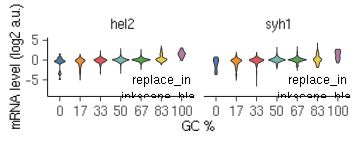

In [16]:
options(repr.plot.width = 3, repr.plot.height = 1.2)

gc_lfc %>%
    mutate(genotype = case_when(genotype == 'wt' ~ 'wild-type',
                                genotype == 'hel2' ~ ' hel2',
                                genotype == 'syh1' ~ ' syh1')) %>%
    mutate(genotype = factor(genotype, levels=c('wild-type', ' hel2', ' syh1'))) %>%
    ggplot() +
    geom_violin(size=0.2) +
    aes(x=gc_content, y=lfc, fill=gc_content) +
    facet_wrap(~genotype) +
    scale_y_continuous(limits=c(-8.5,5)) +
    theme + 
    theme(
        axis.line = element_blank(),
        legend.text=element_blank(),
        strip.text.x = element_text(size=8)
        ) +
    ggthemes::scale_fill_tableau() +
    annotate('text', x=6, y=-7, size=7/.pt, label='replace_in\npost_processing') +
    labs(x='GC %', y='mRNA level (log2 a.u.)') +
    guides(fill="none")

ggsave("../figures/sfig2_gc_lfc_corr.pdf", width=3.5, height=2)

In [17]:
label_data <- gc_lfc %>% 
  filter(genotype != 'wt') %>%
  mutate(genotype = case_when(genotype == 'wt' ~ 'wild-type',
                                genotype == 'hel2' ~ ' hel2',
                                genotype == 'syh1' ~ ' syh1')) %>%
    mutate(genotype = factor(genotype, levels=c('wild-type', ' hel2', ' syh1'))) %>%
  group_by(genotype) %>% 
  nest() %>% 
  mutate(n = map_int(data, nrow), fit = map(data, function(df) cor.test(~gc + lfc, data = df))) %>% 
  mutate(fit = map(fit, broom::tidy)) %>% 
  unnest(fit, n) %>% 
  select(-data) %>%
  mutate(estimate = paste0("r=", round(estimate, 2)))

label_data

Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(fit, n))`, with `mutate()` if needed”


genotype,n,estimate,statistic,p.value,parameter,conf.low,conf.high,method,alternative
<fct>,<int>,<chr>,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<chr>,<chr>
hel2,3509,r=0.35,21.79970,6.517490e-99,3507,0.3159746,0.3742627,Pearson's product-moment correlation,two.sided
syh1,3516,r=0.25,15.35607,1.470874e-51,3514,0.2195337,0.2814925,Pearson's product-moment correlation,two.sided


Warning message:
“Removed 1 rows containing non-finite values (`stat_ydensity()`).”
Warning message:
“Removed 1 rows containing non-finite values (`stat_ydensity()`).”


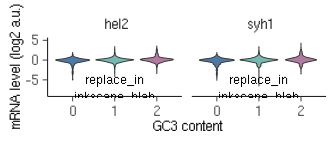

In [18]:
options(repr.plot.width = 2.8, repr.plot.height = 1.2)

gc_lfc %>%
    mutate(genotype = case_when(genotype == 'wt' ~ 'wild-type',
                                genotype == 'hel2' ~ ' hel2',
                                genotype == 'syh1' ~ ' syh1')) %>%
    mutate(genotype = factor(genotype, levels=c('wild-type', ' hel2', ' syh1'))) %>%
    ggplot() +
    aes(x=gc3_content, y=lfc, fill=as.factor(gc3_content)) +
    facet_wrap(~genotype) +
    geom_violin(size=0.2) +
    scale_y_continuous(limits=c(-8.5,5)) +
    theme + 
    theme(
        axis.line = element_blank(),
        legend.text=element_blank(),
        strip.text.x = element_text(size=8)
        ) +
    scale_fill_manual(values=c('0'='#4e79a7', '1'='#76b7b2', '2'='#b07aa1')) +
    annotate('text', x=1, y=-7, size=7/.pt, label='replace_in\npost_processing') +
    labs(x='GC3 content', y='mRNA level (log2 a.u.)') +
    guides(fill="none")

ggsave("../figures/sfig2_wt_gc3_lfc_corr.pdf", width=2.5, height=2)

In [19]:
label_data <- gc_lfc %>% 
  mutate(genotype = case_when(genotype == 'wt' ~ 'wild-type',
                                genotype == 'hel2' ~ ' hel2',
                                genotype == 'syh1' ~ ' syh1')) %>%
    mutate(genotype = factor(genotype, levels=c('wild-type', ' hel2', ' syh1'))) %>%
  group_by(genotype) %>% 
  nest() %>% 
  mutate(n = map_int(data, nrow), fit = map(data, function(df) cor.test(~gc3_content + lfc, data = df))) %>% 
  mutate(fit = map(fit, broom::tidy)) %>% 
  unnest(fit, n) %>% 
  select(-data) %>%
  mutate(estimate = paste0("r=", round(estimate, 2)))

label_data

Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(fit, n))`, with `mutate()` if needed”


genotype,n,estimate,statistic,p.value,parameter,conf.low,conf.high,method,alternative
<fct>,<int>,<chr>,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<chr>,<chr>
hel2,3509,r=0.19,11.74841,2.755671e-31,3507,0.1625513,0.2262260,Pearson's product-moment correlation,two.sided
syh1,3516,r=0.18,10.95267,1.785316e-27,3514,0.1495315,0.2134635,Pearson's product-moment correlation,two.sided


### Plot targeted deep-seq for Hel2-del

In [20]:
barcode_counts_mini  <- list.files("../../wt_hel2_mini_pool/data/linked_barcode_counts/", pattern = ".csv$", full.names = T) %>% 
  enframe("sno", "file") %>% 
  mutate(counts = map(file, read_csv)) %>% 
  mutate(sample_name = str_extract(file, "[^/]+(?=.csv)")) %>% 
  select(-sno, -file) %>% 
  unnest() %>% 
  mutate(insert_num = as.numeric(str_extract(insert_num, "[:digit:]+"))) %>%
  mutate(barcode_count = as.numeric(barcode_count)) %>%
  mutate(linkage_count = as.numeric(linkage_count))

Rows: 1209 Columns: 5
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): barcode_count, insert_num, barcode, linkage_count
dbl (1): barcode_num

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 1209 Columns: 5
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): barcode_count, insert_num, barcode, linkage_count
dbl (1): barcode_num

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 922 Columns: 5
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): barcode_count, insert_num, barcode, linkage_count
dbl (1): barcode_num

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column typ

In [21]:
insert_annotations_mini <- read_csv("../../mini_8xdicodon_linkage/annotations/dicodon_yeast.csv") %>%
    mutate(diaa = as.character(translate(DNAStringSet(insert), no.init.codon = T))) %>%
    mutate(diaa = str_sub(diaa, 9,10)) %>%
    mutate(dicodon = str_sub(insert, 25,30)) %>%
    mutate(diaa = ifelse(insert_num == 11, 'spikein2', diaa)) %>%
    mutate(diaa = ifelse(insert_num == 12, 'spikein2', diaa))

Rows: 13 Columns: 2
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (1): insert
dbl (1): insert_num

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Warning message in .Call2("DNAStringSet_translate", x, skip_code, dna_codes[codon_alphabet], :
“in 'x[[1]]': last 2 bases were ignored”
Warning message in .Call2("DNAStringSet_translate", x, skip_code, dna_codes[codon_alphabet], :
“in 'x[[2]]': last 2 bases were ignored”
Warning message in .Call2("DNAStringSet_translate", x, skip_code, dna_codes[codon_alphabet], :
“in 'x[[3]]': last 2 bases were ignored”
Warning message in .Call2("DNAStringSet_translate", x, skip_code, dna_codes[codon_alphabet], :
“in 'x[[4]]': last 2 bases were ignored”
Warning message in .Call2("DNAStringSet_translate", x, skip_code, dna_codes[codon_alphabet], :
“in 'x[[5]]': last 2 bases were ignored”
Warning messa

In [22]:
include <- c("AAGGGA", "TTAAGT", "GTGAAA", "AAAGTG", "TTTAAG", "AAGAAG")
insert_reads_cutoff <- 15
AMINO_ACID_CODE["*"] = "*"

calc_lfc_bootstrap <- function(data, indices) {
  d <- data[indices,]
  log2(sum(d$mrna)) - log2(sum(d$gdna))
}

diaa_lfc_boot_wt_mini <- barcode_counts_mini %>%
  left_join(insert_annotations_mini, by='insert_num') %>%
  mutate(sample_type = str_extract(sample_name, '[^_]+$')) %>%
  mutate(genotype = str_extract(sample_name, '[^_]+')) %>%
  filter(genotype == 'wt') %>%
  select(-barcode, -linkage_count, -sample_name) %>%
  pivot_wider(names_from = c(sample_type), values_from = barcode_count) %>%
  filter((mrna >= insert_reads_cutoff) & (gdna >= insert_reads_cutoff)) %>%
  drop_na() %>%
  group_by(insert_num) %>%
  nest() %>%
  mutate(lfc_boot = map(data, function(df) boot::boot(data=df, statistic=calc_lfc_bootstrap, R=100)$t)) %>%
  select(-data) %>%
  mutate(lfc = map_dbl(lfc_boot, mean)) %>%
  mutate(lfc_sd = map_dbl(lfc_boot, sd)) %>%
  select(-lfc_boot) %>%
  ungroup() %>%
  inner_join(insert_annotations_mini, by = "insert_num") %>%
  mutate(strain = 'WT')

diaa_lfc_boot_hel2_mini <- barcode_counts_mini %>%
  left_join(insert_annotations_mini, by='insert_num') %>%
  mutate(sample_type = str_extract(sample_name, '[^_]+$')) %>%
  mutate(genotype = str_extract(sample_name, '[^_]+')) %>%
  filter(genotype == 'hel2') %>%
  select(-barcode, -linkage_count, -sample_name) %>%
  pivot_wider(names_from = c(sample_type), values_from = barcode_count) %>%
  filter((mrna >= insert_reads_cutoff) & (gdna >= insert_reads_cutoff)) %>%
  drop_na() %>%
  group_by(insert_num) %>%
  nest() %>%
  mutate(lfc_boot = map(data, function(df) boot::boot(data=df, statistic=calc_lfc_bootstrap, R=100)$t)) %>%
  select(-data) %>%
  mutate(lfc = map_dbl(lfc_boot, mean)) %>%
  mutate(lfc_sd = map_dbl(lfc_boot, sd)) %>%
  select(-lfc_boot) %>%
  ungroup() %>%
  inner_join(insert_annotations_mini, by = "insert_num") %>%
  mutate(strain = 'Hel2-del')

In [23]:
barcode_counts_mini %>% 
  filter(str_detect(sample_name,'wt')) %>%
  left_join(insert_annotations_mini, by='insert_num') %>%
  filter(dicodon %in% include) %>%
  mutate(sample_type = str_extract(sample_name, '[^_]+$')) %>%
  mutate(genotype = str_extract(sample_name, '[^_]+')) %>%
  select(-barcode_num, -sample_name, -linkage_count) %>%
  pivot_wider(names_from = sample_type, values_from = barcode_count) %>%
  filter((mrna >= insert_reads_cutoff) & (gdna >= insert_reads_cutoff)) %>%
  drop_na() %>%
  group_by(dicodon) %>%
  summarize(n_barc = n()) %>%
  mutate(avg = mean(n_barc), md = median(n_barc)) %>%
  slice(1) %>%
  select(-dicodon, -n_barc)

barcode_counts_mini %>% 
  filter(str_detect(sample_name,'hel2')) %>%
  left_join(insert_annotations_mini, by='insert_num') %>%
  filter(dicodon %in% include) %>%
  mutate(sample_type = str_extract(sample_name, '[^_]+$')) %>%
  mutate(genotype = str_extract(sample_name, '[^_]+')) %>%
  select(-barcode_num, -sample_name, -linkage_count) %>%
  pivot_wider(names_from = sample_type, values_from = barcode_count) %>%
  filter((mrna >= insert_reads_cutoff) & (gdna >= insert_reads_cutoff)) %>%
  drop_na() %>%
  group_by(dicodon) %>%
  summarize(n_barc = n()) %>%
  mutate(avg = mean(n_barc), md = median(n_barc)) %>%
  slice(1) %>%
  select(-dicodon, -n_barc)

avg,md
<dbl>,<dbl>
77.5,26.5


avg,md
<dbl>,<dbl>
127.6667,48


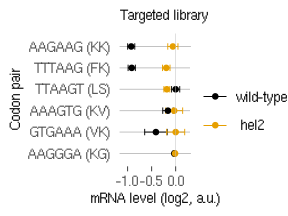

In [37]:
options(repr.plot.width = 2.4, repr.plot.height = 1.8)

order <- c("AAGGGA (KG)", "GTGAAA (VK)", "AAAGTG (KV)", "TTAAGT (LS)", "TTTAAG (FK)", "AAGAAG (KK)")

plot_data <- bind_rows(diaa_lfc_boot_wt_mini, diaa_lfc_boot_hel2_mini) %>%
  filter(dicodon %in% include) %>%
  mutate(strain = ifelse(strain == 'WT', 'wild-type', 'hel2')) %>%
  group_by(strain) %>%
  mutate(lfc_max = lfc - max(lfc)) %>%
  mutate(lfc_med = lfc - median(lfc)) %>%
  ungroup() %>%
  mutate(diaa = str_c(dicodon, " (", diaa, ")")) %>%
  mutate(codon = factor(diaa, level=order)) %>%
  mutate(strain = factor(strain, levels= c('wild-type', 'hel2')))
  
plot_data %>%
  ggplot(aes(x = lfc_max, y = codon,
             xmin = lfc_max - lfc_sd, xmax = lfc_max + lfc_sd, color=strain)) +
  geom_errorbar(width=0.3, size=0.2) +
  geom_point(size=0.8) +
  geom_vline(xintercept=0, color='grey', size=0.1) +
  scale_x_continuous(breaks=seq(-1.5, 0.5, 0.5), limits=c(-1.1, 0.25)) +
  scale_color_manual(values=c('wild-type'='black', 'hel2'='#E69F00')) +
  theme + 
  theme(
      axis.line = element_blank(),
      axis.line.x = element_blank(),
      axis.line.y = element_blank(),
      axis.ticks.y = element_blank(),
      panel.grid.major.y = element_line(color='grey', size=0.2),
      legend.box.margin=margin(-12,-12,-12,-12)) +
  labs(x = "mRNA level (log2, a.u.)", y = "Codon pair", subtitle='Targeted library', color='')

ggsave("../figures/sfig2_targeted_deepseq.pdf", width=3, height=1.8)

### Plot flow data for Hel2-del

In [25]:
fcsfiles_plate1 <- '../../../../data/flow_cytometry/exp44_plate1' %>% 
  list.files(full.names = T)

samplenames_plate1 <- fcsfiles_plate1 %>% 
  stringr::str_match('([^/]+).fcs$') %>% 
  magrittr::extract(,2)

In [26]:
flowdata_plate1  <- fcsfiles_plate1 %>% 
  lapply(. %>%
         flowCore::read.FCS(transformation = F, alter.names = T) %>% 
         flowCore::exprs() %>%
         as_tibble()) %>%
  set_names(samplenames_plate1) %>% 
  bind_rows(.id = 'file') %>% 
  mutate_at(vars(contains('FITC|TexasRd')), funs(. - 2 * min(.)))  %>%
  mutate(tube = as.integer(str_extract(file, "[:digit:]+$")))

Warning message in readFCSdata(con, offsets, txt, transformation, which.lines, scale, :
“Some data values of 'PE.TexasRd.A' channel exceed its $PnR value 262144 and will be truncated!
 To avoid truncation, either fix $PnR before generating FCS or set 'truncate_max_range = FALSE'”
Warning message in readFCSdata(con, offsets, txt, transformation, which.lines, scale, :
“Some data values of 'FSC.A' channel exceed its $PnR value 262144 and will be truncated!
 To avoid truncation, either fix $PnR before generating FCS or set 'truncate_max_range = FALSE'”
Warning message in readFCSdata(con, offsets, txt, transformation, which.lines, scale, :
“Some data values of 'PE.TexasRd.A' channel exceed its $PnR value 262144 and will be truncated!
 To avoid truncation, either fix $PnR before generating FCS or set 'truncate_max_range = FALSE'”
Warning message in readFCSdata(con, offsets, txt, transformation, which.lines, scale, :
“Some data values of 'FSC.A' channel exceed its $PnR value 262144 and will b

In [27]:
annotations_plate1 <- read_csv("../../../flow_cytometry/wt_hel2_8xdicodon/annotations/sample_annotations_plates.csv") %>% 
  filter(plate == "1") %>%
  janitor::clean_names() %>% 
  mutate(file = str_extract(file, '([a-zA-Z]*)_([:digit:]+)_([A-Z][:digit:]+)_([A-Z][:digit:]+)'))

Rows: 96 Columns: 7
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (6): Desc, plasmid_RefID, parent_strain, flow_label, file, order
dbl (1): plate

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [28]:
data1 <- flowdata_plate1 %>% 
  left_join(annotations_plate1, by = 'file') %>%
  select(-tube, -plate)

In [29]:
fcsfiles_plate2 <- '../../../../data/flow_cytometry/exp44_plate2' %>% 
  list.files(full.names = T) 

samplenames_plate2 <- fcsfiles_plate2 %>% 
  stringr::str_match('([^/]+).fcs$') %>% 
  magrittr::extract(,2) 

flowdata_plate2  <- fcsfiles_plate2 %>% 
  lapply(. %>%
         flowCore::read.FCS(transformation = F, alter.names = T) %>% 
         flowCore::exprs() %>%
         as_tibble()) %>%
  set_names(samplenames_plate2) %>% 
  bind_rows(.id = 'file') %>% 
  mutate_at(vars(contains('FITC|TexasRd')), funs(. - 2 * min(.)))  %>%
  mutate(tube = as.integer(str_extract(file, "[:digit:]+$")))

annotations_plate2 <- read_csv("../../../flow_cytometry/wt_hel2_8xdicodon/annotations/sample_annotations_plates.csv") %>% 
  filter(plate == "2") %>%
  janitor::clean_names() %>% 
  mutate(file = str_extract(file, '([a-zA-Z]*)_([:digit:]+)_([A-Z][:digit:]+)_([A-Z][:digit:]+)'))

data2 <- flowdata_plate2 %>% 
  left_join(annotations_plate2, by = 'file') %>%
  select(-tube, -plate)

Warning message in readFCSdata(con, offsets, txt, transformation, which.lines, scale, :
“Some data values of 'FSC.A' channel exceed its $PnR value 262144 and will be truncated!
 To avoid truncation, either fix $PnR before generating FCS or set 'truncate_max_range = FALSE'”
Warning message in readFCSdata(con, offsets, txt, transformation, which.lines, scale, :
“Some data values of 'SSC.A' channel exceed its $PnR value 262144 and will be truncated!
 To avoid truncation, either fix $PnR before generating FCS or set 'truncate_max_range = FALSE'”
Warning message in readFCSdata(con, offsets, txt, transformation, which.lines, scale, :
“Some data values of 'PE.TexasRd.A' channel exceed its $PnR value 262144 and will be truncated!
 To avoid truncation, either fix $PnR before generating FCS or set 'truncate_max_range = FALSE'”
Warning message in readFCSdata(con, offsets, txt, transformation, which.lines, scale, :
“Some data values of 'PE.TexasRd.A' channel exceed its $PnR value 262144 and will b

In [30]:
all_data <- bind_rows(data1, data2)
control_desc = c("WT", "WT_RFP", "Hel2-KO_RFP", "low_GFP", "high_GFP", "SCD")
alldata <- all_data %>%
  dplyr::rename('PE.Texas.Red.A' = 'PE.TexasRd.A') %>%
  dplyr::select(-order) %>%
  select(-Time) %>%
  mutate(flow_label = ifelse(is.na(flow_label), desc, flow_label)) %>%
  print()

# A tibble: 951,741 × 9
   file                FSC.A SSC.A  FITC.A PE.Te…¹ desc  plasm…² paren…³ flow_…⁴
   <chr>               <dbl> <dbl>   <dbl>   <dbl> <chr> <chr>   <chr>   <chr>  
 1 Specimen_002_B2_B… 25460. 241.    2.33   135.   WT    WT      NA      WT     
 2 Specimen_002_B2_B… 62522. 665.   -0.297  272.   WT    WT      NA      WT     
 3 Specimen_002_B2_B… 34193. 160.  -65.5    -24.8  WT    WT      NA      WT     
 4 Specimen_002_B2_B… 29150.  85.6 -45.5    -18.6  WT    WT      NA      WT     
 5 Specimen_002_B2_B… 83542. -64.8 -74.8    -78.8  WT    WT      NA      WT     
 6 Specimen_002_B2_B… 40400. 342.  -18.4    137.   WT    WT      NA      WT     
 7 Specimen_002_B2_B… 36281. 246.  -15.3     77.3  WT    WT      NA      WT     
 8 Specimen_002_B2_B… 25988. 196.  -11.8      7.81 WT    WT      NA      WT     
 9 Specimen_002_B2_B… 74577. 364.  -17.4    135.   WT    WT      NA      WT     
10 Specimen_002_B2_B… 37459. 262.  -52.3     91.2  WT    WT      NA      WT     
# … 

In [31]:
annotations <- bind_rows(annotations_plate1, annotations_plate2) %>%
  mutate(flow_label = ifelse(is.na(flow_label), desc, flow_label))

In [32]:
med_data_norm <- alldata %>%
  mutate(yfp_norm_rfp = FITC.A / PE.Texas.Red.A) %>% # per cell normalization
  group_by(flow_label, file) %>% # group by each well
  select(yfp_norm_rfp) %>%
  summarise_all(median) %>% # median normalized value of each well
  left_join(annotations, by = c('flow_label', 'file')) %>%
  print()

Adding missing grouping variables: `flow_label`, `file`


# A tibble: 96 × 8
# Groups:   flow_label [24]
   flow_label      file                yfp_n…¹ desc  plasm…² paren…³ plate order
   <chr>           <chr>                 <dbl> <chr> <chr>   <chr>   <dbl> <chr>
 1 Hel2-KO_RFP     Specimen_002_B4_B04 4.57e-4 Hel2… scHP52… NA          1 B04.…
 2 high_GFP        Specimen_002_B6_B06 4.13e-2 high… scHP20… NA          1 B06.…
 3 low_GFP         Specimen_002_B5_B05 4.36e-3 low_… scHP19… NA          1 B05.…
 4 SCD             Specimen_002_B7_B07 4.38e-2 SCD   Media   NA          1 B07.…
 5 scHP15-2-1120.1 Specimen_001_E2_E02 6.21e-2 GPD-… pHPSC1… scHP15…     2 E02.…
 6 scHP15-2-1120.1 Specimen_001_E3_E03 6.08e-2 GPD-… pHPSC1… scHP15…     2 E03.…
 7 scHP15-2-1120.1 Specimen_001_E4_E04 6.13e-2 GPD-… pHPSC1… scHP15…     2 E04.…
 8 scHP15-2-1120.1 Specimen_001_E5_E05 6.12e-2 GPD-… pHPSC1… scHP15…     2 E05.…
 9 scHP15-2-1120.1 Specimen_001_E6_E06 6.15e-2 GPD-… pHPSC1… scHP15…     2 E06.…
10 scHP15-2-1144.1 Specimen_002_C2_C02 2.81e-2 GPD-… pHPSC1… s

In [33]:
# no insert controls are very similar in yfp/rfp between strains
no_insert_cntrls <- med_data_norm %>%
  group_by(desc, parent_strain, flow_label) %>%
  dplyr::filter(str_detect(desc, "cntrl")) %>%
  summarize(no_insert_avg = mean(yfp_norm_rfp)) %>% # avg of the wells per strain
  print()

all_norm_data <- med_data_norm %>% # normalize each well to the mean no-insert value
    left_join(no_insert_cntrls, by=c("parent_strain")) %>%
    dplyr::select(-flow_label.y, -desc.y,) %>%
    dplyr::rename(desc = desc.x) %>%
    dplyr::rename(flow_label = flow_label.x) %>%
    mutate(dicodon = ifelse(desc %in% control_desc, desc, str_extract(desc, "(?<=GPD-3xFLAG-PGK1-HA-8xdicodoon_)([:upper:]+_[:upper:]+)(?=-R1-T7-YFP)"))) %>%
    mutate(dicodon = ifelse(is.na(dicodon), "no_insert_cntrl", dicodon)) %>%
    group_by(parent_strain) %>%
    mutate(yfp_norm_rfp_norm = yfp_norm_rfp/no_insert_avg) %>%
    mutate(log_yfp_norm_rfp_norm = log2(yfp_norm_rfp) - log2(no_insert_avg)) %>%
    ungroup() %>%
    mutate(dicodon = ifelse(plasmid_ref_id == "pHPSC1148.1", "RR_AGAAGA_9x", dicodon)) %>%
    filter(!(yfp_norm_rfp_norm > 10)) %>% # get rid of the one huge outlier
    group_by(flow_label) %>% # all wells belonging to each strain
    mutate(stderr = std.error(yfp_norm_rfp_norm)) %>%
    mutate(stderr_log = std.error(log_yfp_norm_rfp_norm)) %>%
    mutate(diaa = str_split(dicodon, '_')[[1]][1]) %>%
    mutate(aa1 = ifelse(dicodon != 'no_insert_cntrl', str_sub(diaa, 1, 1), 'no_insert_cntrl')) %>%
    mutate(aa2 = ifelse(dicodon != 'no_insert_cntrl', str_sub(diaa, 2, 2), 'no_insert_cntrl')) %>%
    mutate(res1 = ifelse(dicodon != 'no_insert_cntrl', AMINO_ACID_CODE[aa1], 'no_insert_cntrl')) %>%
    mutate(res2 = ifelse(dicodon != 'no_insert_cntrl', AMINO_ACID_CODE[aa2], 'no_insert_cntrl')) %>%
    mutate(dipeptide = ifelse(dicodon != 'no_insert_cntrl', str_c(res1, res2),'no_insert_cntrl')) %>%
    ungroup() %>%
    print()

`summarise()` has grouped output by 'desc', 'parent_strain'. You can override
using the `.groups` argument.


# A tibble: 2 × 4
# Groups:   desc, parent_strain [2]
  desc                               parent_strain flow_label       no_insert_…¹
  <chr>                              <chr>         <chr>                   <dbl>
1 GPD-3xFLAG-PGK1-HA-cntrl-R1-T7-YFP scHP15-2      scHP15-2-1120.1        0.0614
2 GPD-3xFLAG-PGK1-HA-cntrl-R1-T7-YFP scHP520.1     scHP520.1-1120.1       0.0616
# … with abbreviated variable name ¹​no_insert_avg
# A tibble: 89 × 20
   flow_label    file  yfp_n…¹ desc  plasm…² paren…³ plate order no_in…⁴ dicodon
   <chr>         <chr>   <dbl> <chr> <chr>   <chr>   <dbl> <chr>   <dbl> <chr>  
 1 scHP15-2-112… Spec…  0.0621 GPD-… pHPSC1… scHP15…     2 E02.…  0.0614 no_ins…
 2 scHP15-2-112… Spec…  0.0608 GPD-… pHPSC1… scHP15…     2 E03.…  0.0614 no_ins…
 3 scHP15-2-112… Spec…  0.0613 GPD-… pHPSC1… scHP15…     2 E04.…  0.0614 no_ins…
 4 scHP15-2-112… Spec…  0.0612 GPD-… pHPSC1… scHP15…     2 E05.…  0.0614 no_ins…
 5 scHP15-2-112… Spec…  0.0615 GPD-… pHPSC1… scHP15…     2 E06.… 

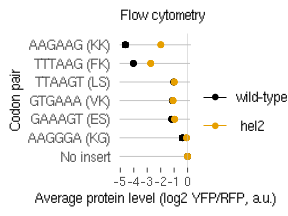

In [35]:
options(repr.plot.width = 2.4, repr.plot.height = 1.8)

order <- c("No insert", 'AAGGGA (KG)', 'GAAAGT (ES)', "GTGAAA (VK)", "TTAAGT (LS)", "TTTAAG (FK)", "AAGAAG (KK)")

all_norm_data %>%
  select(-desc, -plate, -order) %>%
  group_by(flow_label) %>%
  mutate(codons = str_split(dicodon, '_')[[1]][2]) %>%
  mutate(dipep2 = ifelse(dicodon != 'no_insert_cntrl', str_c(codons, " (", diaa, ")" ), 'No insert')) %>%
  filter(dipep2 %in% order) %>%
  mutate(mean = mean(log_yfp_norm_rfp_norm)) %>%
  mutate(facet = factor(dipep2, levels=order)) %>%
  mutate(Strain = ifelse(parent_strain == 'scHP15-2', 'wild-type', 'hel2')) %>%
  mutate(Strain = factor(Strain, levels= c('wild-type', 'hel2'))) %>%
  ggplot(aes(y=facet, x=mean, xmax = mean + stderr_log, xmin = mean - stderr_log, color=Strain)) +
  geom_errorbar(width=0.3, size=0.2) +
  geom_point(size=0.8) +
  geom_vline(xintercept=0, color='grey', size=0.1) +
  scale_color_manual(values=c('wild-type'='black', 'hel2'='#E69F00')) +
  theme + 
  theme(
      axis.line = element_blank(),
      axis.line.x = element_blank(),
      axis.line.y = element_blank(),
      axis.ticks.y = element_blank(),
      panel.grid.major.y = element_line(color='grey', size=0.2),
      axis.text.x = element_text(size=7),
      legend.box.margin=margin(-12,-12,-12,-12),
      ) +
  labs(y="Codon pair", x="Average protein level (log2 YFP/RFP, a.u.)", subtitle='Flow cytometry', color='')

ggsave("../figures/sfig2_select_dicodons_flow_wt_hel2.pdf", width=3, height=1.8)